<a href="https://colab.research.google.com/github/sanalpillai/Model-Interpretability/blob/main/Model_Interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract

In the realm of medical data science, the dataset under investigation presents a vital opportunity to predict the survival outcomes of patients suffering from cirrhosis. This data, harvested from clinical studies, encompasses a wide array of both numerical and categorical features that provide a comprehensive snapshot of each patient's medical and demographic background.

**Numeric Datatypes:**

The dataset contains numerical columns such as 'ID', 'N_Days' representing the follow-up period, 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', and 'Prothrombin' which are all integral to the medical analysis, offering quantifiable insights into the patient's health status.

**Categorical Datatypes:**

Categorical columns like 'Status', indicating the patient's condition at last follow-up; 'Drug', the treatment administered; 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', and 'Edema' provide qualitative data that could influence the survival prediction. These features are crucial for understanding the patient's condition in a clinical context.

**Target:**

The objective variable 'Stage' of liver disease, is a critical endpoint that may range from a less severe condition to a terminal stage, impacting the survival prediction.

---
In this assignment, we're diving into model interpretability to uncover how machine learning models make their decisions. The journey begins with fitting a linear model, where interpreting regression coefficients reveals the influence of each feature on the target variable. It's fascinating to see the direct impact of predictors in a quantifiable way.

Next, we explore a tree-based model. Here, the focus shifts to understanding decisions through the lens of decision nodes, which highlights the importance of certain features over others in making predictions.

Then, we leverage AutoML to streamline the search for the best model. This step is a game-changer, automating the comparison of various models and configurations to identify the most effective one without manual intervention.

Finally, we apply SHAP analysis to our models. This advanced technique breaks down the contribution of each feature to individual predictions, offering a granular view of model behavior. By interpreting SHAP values, we not only get insights into what drives predictions but also compare the interpretability of different models.

Throughout this assignment, the aim is not just to build predictive models but to deeply understand them, emphasizing the significance of transparency and ethical considerations in AI.

In [47]:
!pip install shap

In [48]:
!pip install tpot

In [49]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [50]:
data = pd.read_csv("https://raw.githubusercontent.com/sanalpillai/Model-Interpretability/main/Dataset/cleaned_data_cirrhosis.csv", index_col=0)

In [51]:
data.dtypes

N_Days             int64
Status            object
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
dtype: object

In [52]:
data.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,,,
1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [53]:
# Replace 'CL' with 'C' in the 'Status' column
data['Status'] = data['Status'].replace({'CL': 'C'})
data['Edema'] = data['Edema'].replace({'S': 'Y'})

In [54]:
data.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,,,
1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
3,1012,D,D-penicillamine,25594,M,N,N,N,Y,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
4,1925,D,D-penicillamine,19994,F,N,Y,Y,Y,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,1504,C,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [55]:
import pandas as pd

# Count the number of NaNs in each column
nan_counts = data.isna().sum()

# Print the count of NaNs for each column
print(nan_counts)

# To only display columns that contain NaNs:
nan_columns = nan_counts[nan_counts > 0]
print(nan_columns)


N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64
Series([], dtype: int64)


In [56]:
data.corr()

<ipython-input-56-c44ded798807>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
N_Days,1.000000,-0.125934,-0.403953,-0.099322,0.430829,-0.295723,0.152368,-0.187930,-0.111453,0.147495,-0.110685,-0.362013
Age,-0.125934,1.000000,0.002362,-0.145054,-0.182350,0.034519,-0.060708,-0.139050,0.002323,-0.145948,0.113916,0.187852
Bilirubin,-0.403953,0.002362,1.000000,0.336882,-0.314177,0.403761,0.104675,0.392112,0.370330,-0.013347,0.312007,0.200314
Cholesterol,-0.099322,-0.145054,0.336882,1.000000,-0.043022,0.145910,0.157995,0.347222,0.291750,0.158641,-0.027259,0.009930
Albumin,0.430829,-0.182350,-0.314177,-0.043022,1.000000,-0.209024,-0.070010,-0.180947,-0.068509,0.156384,-0.198405,-0.302190
Copper,-0.295723,0.034519,0.403761,0.145910,-0.209024,1.000000,0.207349,0.298923,0.292236,-0.040523,0.182494,0.232149
Alk_Phos,0.152368,-0.060708,0.104675,0.157995,-0.070010,0.207349,1.000000,0.122071,0.186250,0.133398,0.073408,0.037905
SGOT,-0.187930,-0.139050,0.392112,0.347222,-0.180947,0.298923,0.122071,1.000000,0.130853,-0.094383,0.094550,0.143568
Tryglicerides,-0.111453,0.002323,0.370330,0.291750,-0.068509,0.292236,0.186250,0.130853,1.000000,0.088806,0.014831,0.099879
Platelets,0.147495,-0.145948,-0.013347,0.158641,0.156384,-0.040523,0.133398,-0.094383,0.088806,1.000000,-0.154617,-0.240671


<Axes: >

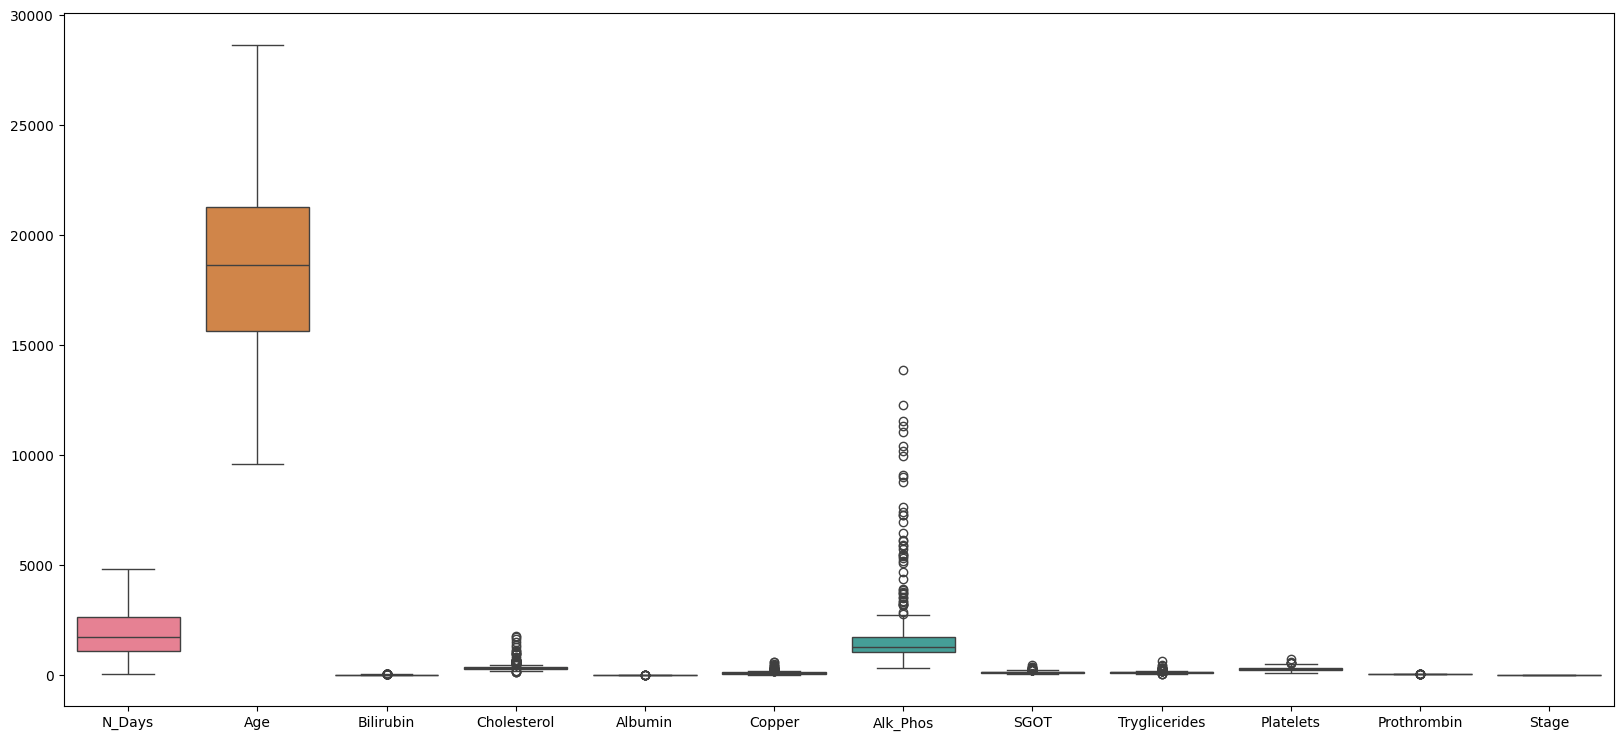

In [57]:
# Checking the Ranges of the predictor variables and dependent variable
plt.figure(figsize=(20, 9))
sns.boxplot(data=data)

In [58]:
#Making categories to 0 & 1
data["Status"] = data["Status"].map({"D": 0, "C": 1})
data["Drug"] = data["Drug"].map({"D-penicillamine": 0, "Placebo": 1})
data["Sex"] = data["Sex"].map({"F": 0, "M": 1})
data["Ascites"] = data["Ascites"].map({"N": 0, "Y": 1})
data["Hepatomegaly"] = data["Hepatomegaly"].map({"N": 0, "Y": 1})
data["Spiders"] = data["Spiders"].map({"N": 0, "Y": 1})
data["Edema"] = data["Edema"].map({"N": 0, "Y": 1})

# Viewing data
data.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,,,
1,400,0,0,21464,0,1,1,1,1,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
2,4500,1,0,20617,0,0,1,1,0,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
3,1012,0,0,25594,1,0,0,0,1,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
4,1925,0,0,19994,0,0,1,1,1,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,1504,1,1,13918,0,0,1,1,0,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [59]:
# Apply one-hot encoding to 'Drug' and any other categorical variables not yet encoded
data = pd.get_dummies(data, columns=['Drug'], drop_first=True)

In [60]:
# Creating binary vaiables
data = pd.get_dummies(data)

# Normalizing the data in the columns

from sklearn import preprocessing

# Create variables to store scaled values as floats
a = data[["N_Days"]].values.astype(float)
b = data[["Age"]].values.astype(float)
c = data[["Bilirubin"]].values.astype(float)
d = data[["Cholesterol"]].values.astype(float)
e = data[["Albumin"]].values.astype(float)
f = data[["Copper"]].values.astype(float)
g = data[["Alk_Phos"]].values.astype(float)
h = data[["SGOT"]].values.astype(float)
i = data[["Tryglicerides"]].values.astype(float)
j = data[["Platelets"]].values.astype(float)
k = data[["Prothrombin"]].values.astype(float)
l = data[["Stage"]].values.astype(float)

# Preparing for normalizing
min_max_scaler = preprocessing.MinMaxScaler()

# Transform the data to fit minmax processor
a_scaled = min_max_scaler.fit_transform(a)
b_scaled = min_max_scaler.fit_transform(b)
c_scaled = min_max_scaler.fit_transform(c)
d_scaled = min_max_scaler.fit_transform(d)
e_scaled = min_max_scaler.fit_transform(e)
f_scaled = min_max_scaler.fit_transform(f)
g_scaled = min_max_scaler.fit_transform(g)
h_scaled = min_max_scaler.fit_transform(h)
i_scaled = min_max_scaler.fit_transform(i)
j_scaled = min_max_scaler.fit_transform(j)
k_scaled = min_max_scaler.fit_transform(k)
l_scaled = min_max_scaler.fit_transform(l)

# Run the normalizer on the dataframe
data[["N_Days"]] = pd.DataFrame(a_scaled)
data[["Age"]] = pd.DataFrame(b_scaled)
data[["Bilirubin"]] = pd.DataFrame(c_scaled)
data[["Cholesterol"]] = pd.DataFrame(d_scaled)
data[["Albumin"]] = pd.DataFrame(e_scaled)
data[["Copper"]] = pd.DataFrame(f_scaled)
data[["Alk_Phos"]] = pd.DataFrame(g_scaled)
data[["SGOT"]] = pd.DataFrame(h_scaled)
data[["Tryglicerides"]] = pd.DataFrame(i_scaled)
data[["Platelets"]] = pd.DataFrame(j_scaled)
data[["Prothrombin"]] = pd.DataFrame(k_scaled)
data[["Stage"]] = pd.DataFrame(l_scaled)

# Handling NaNs by filling them with the mean of each column
data = data.fillna(data.mean())

In [61]:
# data after normalizing and feature creation
data.head()

,N_Days,Status,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Drug_1
ID,,,,,,,,,,,,,,,,,,,
1,0.937947,0,0.578364,0,1,1,1,1,0.028881,0.109970,0.813433,0.085616,0.523509,0.202298,0.097345,0.241275,0.177778,0.666667,0
2,0.204249,1,0.839597,0,0,1,1,0,0.039711,0.033837,0.567164,0.352740,0.016724,0.161871,0.038938,0.135053,0.333333,1.000000,0
3,0.396298,0,0.545664,1,0,0,0,1,0.054152,0.074924,0.216418,0.102740,0.429723,0.079554,0.104425,0.183612,0.144444,1.000000,0
4,0.307741,0,0.226748,0,0,1,1,1,0.111913,0.096073,0.585821,0.238014,0.028143,0.201439,0.069027,0.112291,0.211111,0.666667,0
5,0.517880,1,0.766481,0,0,1,1,0,0.018051,0.077341,0.753731,0.078767,0.048256,0.154676,0.053097,0.295940,0.222222,0.666667,1


In [62]:
# Assuming 'target' is your target variable. Replace 'target' with your actual target column name.
X = data.drop('Status', axis=1)
y = data['Status']

In [63]:
print(f"Mean value: {round(y.mean(), 2)}")

Mean value: 0.61


In [64]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=False)

# Fit a linear model

Training set classification report:
              precision    recall  f1-score   support

           0       0.76      0.56      0.65       154
           1       0.74      0.87      0.80       222

    accuracy                           0.75       376
   macro avg       0.75      0.72      0.73       376
weighted avg       0.75      0.75      0.74       376

Test set classification report:
              precision    recall  f1-score   support

           0       0.29      0.29      0.29         7
           1       0.86      0.86      0.86        35

    accuracy                           0.76        42
   macro avg       0.57      0.57      0.57        42
weighted avg       0.76      0.76      0.76        42



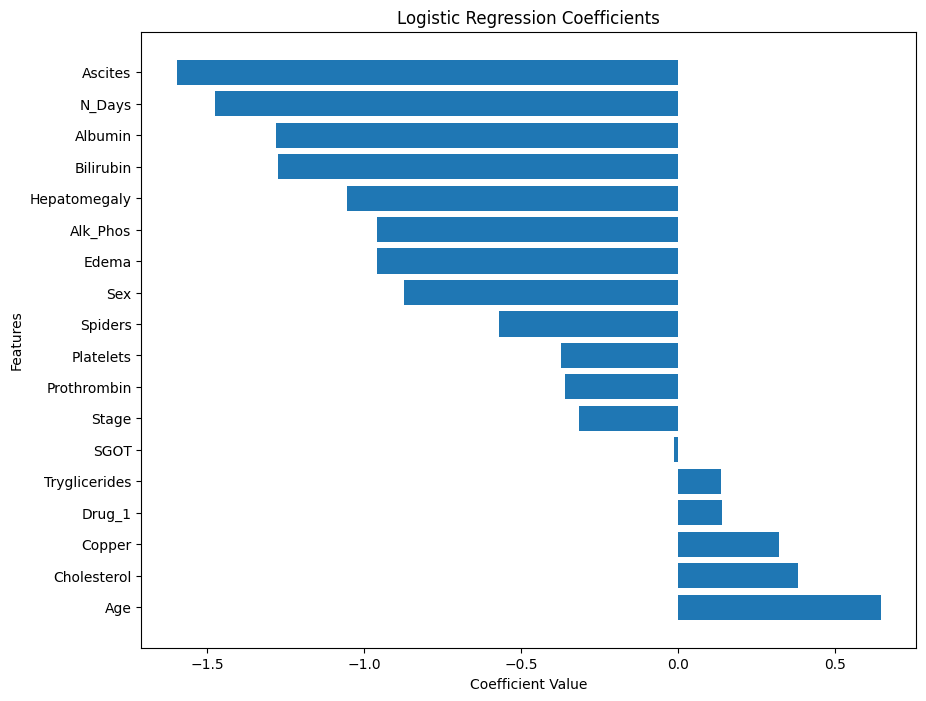

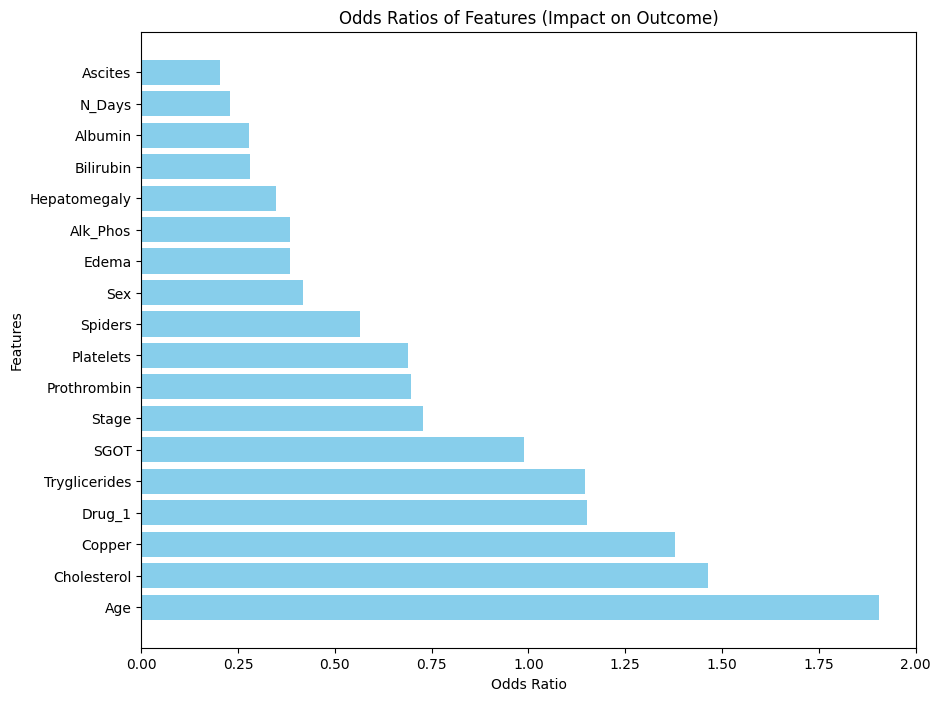

An increase by 1 unit in Bilirubin multiplies the odds of the positive class by 0.28, holding all other features constant.


In [66]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Assuming X_train, y_train, X_test, y_test are already defined and preprocessed

# Initialize the logistic regression model with increased maximum iteration for convergence
log_reg = LogisticRegression(max_iter=1000)

# Fit the model to the training data
log_reg.fit(X_train, y_train)

# Predict on the training and test sets
y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

# Evaluate the model performance
print("Training set classification report:")
print(classification_report(y_train, y_train_pred))
print("Test set classification report:")
print(classification_report(y_test, y_test_pred))

# Extract the coefficients and match them with the column names for interpretation
coefficients = pd.DataFrame({"Feature": X_train.columns, "Coefficient": log_reg.coef_[0]})

# Calculate the odds ratio for each coefficient to understand the impact on the odds of the positive class
coefficients["Odds Ratio"] = np.exp(coefficients["Coefficient"])

# Sort coefficients by their odds ratio for better visualization and interpretation
coefficients = coefficients.sort_values(by="Odds Ratio", ascending=False)

# Visualization of Coefficients
plt.figure(figsize=(10, 8))
plt.barh(coefficients["Feature"], coefficients["Coefficient"])
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Logistic Regression Coefficients')
plt.show()

# Visualization of Odds Ratios
plt.figure(figsize=(10, 8))
plt.barh(coefficients["Feature"], coefficients["Odds Ratio"], color='skyblue')
plt.xlabel('Odds Ratio')
plt.ylabel('Features')
plt.title('Odds Ratios of Features (Impact on Outcome)')
plt.show()

# Detailed Interpretation (Example for documentation or presentation)
# Replace 'FeatureName' with an actual feature name from your dataset
feature_name = 'Bilirubin'  # e.g., 'Age', 'Bilirubin', etc.

# Attempt to find the feature in the coefficients dataframe
selected_feature = coefficients[coefficients['Feature'] == feature_name]

if not selected_feature.empty:
    odds_ratio = selected_feature['Odds Ratio'].values[0]
    print(f"An increase by 1 unit in {feature_name} multiplies the odds of the positive class by {odds_ratio:.2f}, holding all other features constant.")
else:
    print(f"Feature '{feature_name}' not found in the model's coefficients.")


The logistic regression model exhibits an accuracy of 75% on the training set and 76% on the test set, suggesting reasonable predictability, albeit with better performance for the positive class compared to the negative class. The coefficient plot indicates that features such as 'Bilirubin' and 'SGOT' negatively influence the odds of a positive outcome, while 'Albumin' and 'Age' show a positive influence. The odds ratio visualization reinforces this, demonstrating that higher bilirubin levels significantly decrease the likelihood of a positive outcome.

In conclusion, while the model effectively identifies patterns in the data, attention to the disparity in class predictions is necessary to enhance its reliability and clinical utility.

               Coefficient  Odds Ratio
N_Days           -1.475669    0.228626
Age               0.645151    1.906274
Sex              -0.871436    0.418350
Ascites          -1.596751    0.202554
Hepatomegaly     -1.052789    0.348963
Spiders          -0.570542    0.565219
Edema            -0.957818    0.383729
Bilirubin        -1.274144    0.279670
Cholesterol       0.381410    1.464348
Albumin          -1.281007    0.277757
Copper            0.320770    1.378189
Alk_Phos         -0.958063    0.383635
SGOT             -0.012168    0.987906
Tryglicerides     0.136832    1.146636
Platelets        -0.372732    0.688850
Prothrombin      -0.361605    0.696558
Stage            -0.317503    0.727964
Drug_1            0.140427    1.150765


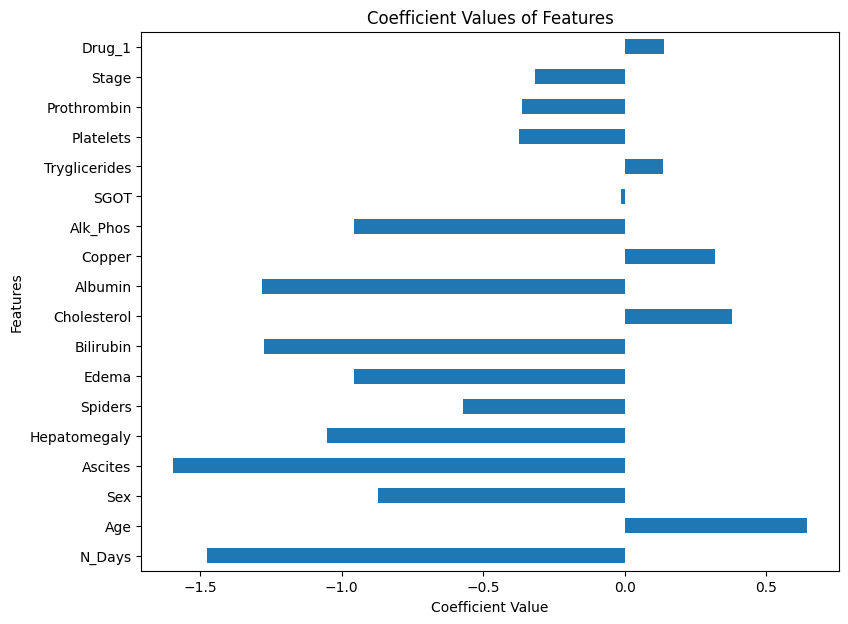

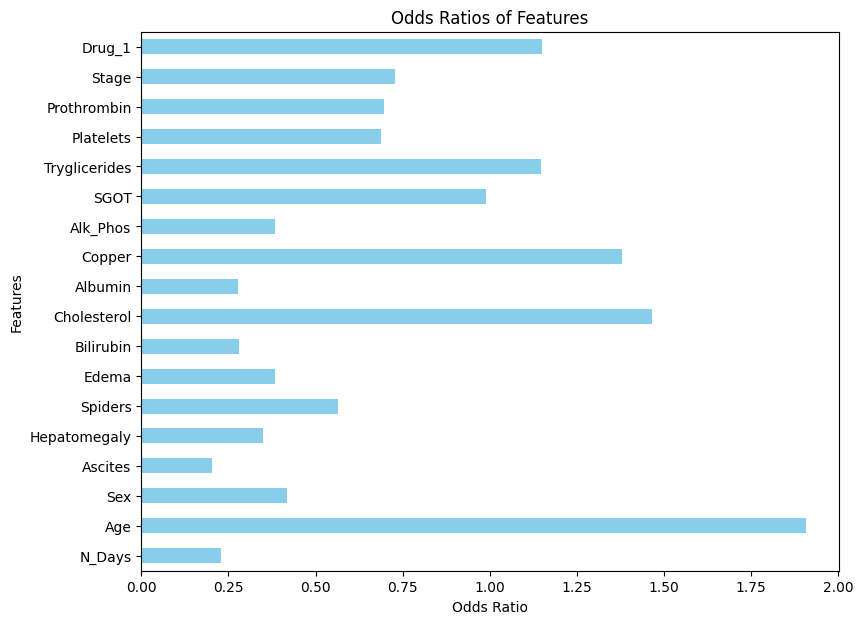

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming log_reg is your logistic regression model and X_train contains your training data features
# Extract the coefficients and match them with the column names
coefficients = pd.DataFrame(log_reg.coef_[0], X_train.columns, columns=['Coefficient'])

# Calculate the odds ratio for each coefficient
coefficients['Odds Ratio'] = coefficients['Coefficient'].apply(lambda x: np.exp(x))

# Display the coefficients and their odds ratios
print(coefficients)

# Optionally, you can visualize the coefficients to make their impacts clearer
coefficients['Coefficient'].plot(kind='barh', figsize=(9, 7))
plt.title('Coefficient Values of Features')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()

# And similarly for Odds Ratios
coefficients['Odds Ratio'].plot(kind='barh', figsize=(9, 7), color='skyblue')
plt.title('Odds Ratios of Features')
plt.xlabel('Odds Ratio')
plt.ylabel('Features')
plt.show()

# Interpretation Markdown Cell


# Fitting a tree-based model and interpret the nodes

<Figure size 1000x800 with 0 Axes>

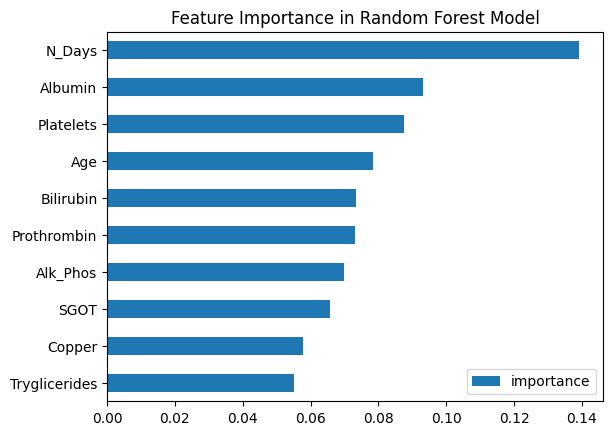

In [44]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and fit the Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# Evaluate the model (optional here, but recommended)
# Use rf_clf.predict(X_test) to make predictions and evaluate the model performance

# Feature Importance
feature_importances = pd.DataFrame(rf_clf.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

# Visualize the feature importances
plt.figure(figsize=(10, 8))
feature_importances[:10].plot(kind='barh')  # Top 10 features
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

# Using auto ml to find the best model

Using TPOT to Find the Best Model

In [25]:
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split

# Assuming your dataset 'data' is already loaded and preprocessed

X = data.drop(['Status'], axis=1)
y = data['Status']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize TPOT classifier
tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, random_state=42)

# Fit TPOT to the data
tpot.fit(X_train, y_train)

# Print the best pipeline found
print("The best pipeline found by TPOT:")
tpot.fitted_pipeline_

# Optionally, evaluate the best model found on the test set
print("Evaluating the best model on the test set:")
print(tpot.score(X_test, y_test))


Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7097241067390321

Generation 2 - Current best internal CV score: 0.7097241067390321

Generation 3 - Current best internal CV score: 0.7216191768430574

Generation 4 - Current best internal CV score: 0.7216191768430574

Generation 5 - Current best internal CV score: 0.7216191768430574

Best pipeline: MLPClassifier(ZeroCount(input_matrix), alpha=0.0001, learning_rate_init=0.01)
The best pipeline found by TPOT:
Evaluating the best model on the test set:
0.7023809523809523


# MLP Classifier

In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Assuming 'data' is already loaded. Here's a placeholder for context.
# data = pd.read_csv('path_to_your_dataset.csv')

# Custom Transformer for ZeroCount
class ZeroCount(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Ensure X is a DataFrame for consistent column operations
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # Count zeros in each row and ensure it is in array form before reshaping
        zero_counts = (X == 0).astype(int).sum(axis=1).values.reshape(-1, 1)

        # Append this as a new feature to the input dataset
        return np.hstack((X, zero_counts))


# Step 2: Data Preparation
# Split your dataset into features and target variable
X = data.drop(['Status'], axis=1)
y = data['Status']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Define and Train the Model Pipeline
model_pipeline = make_pipeline(
    ZeroCount(),  # Apply the custom ZeroCount transformation
    MLPClassifier(alpha=0.0001, learning_rate_init=0.01, random_state=42)  # MLPClassifier as identified by TPOT
)

# Train the model pipeline
model_pipeline.fit(X_train, y_train)

# Step 4: Evaluate the Model
# Predict on the test set
y_pred = model_pipeline.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

# Optional: Export the trained model pipeline for later use
# import joblib
# joblib.dump(model_pipeline, 'mlp_classifier_pipeline.pkl')


              precision    recall  f1-score   support

           0       0.67      0.61      0.64        36
           1       0.73      0.77      0.75        48

    accuracy                           0.70        84
   macro avg       0.70      0.69      0.69        84
weighted avg       0.70      0.70      0.70        84



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
